# Import Dependencies

In [1]:
!pip install split-folders


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install keras-tuner


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Import Libraries

In [34]:
import tensorflow as tf
import os
import splitfolders
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import keras_tuner as kt
from tensorflow.keras import layers
from tensorflow.keras.callbacks import Callback
import numpy as np

# Import Dataset

In [13]:
DATA_DIR = 'asl_dataset'
OUTPUT_DIR = 'asl_split_dataset' 

# splitfolders.ratio(DATA_DIR, output=OUTPUT_DIR, seed=42, ratio=(0.64, 0.16, 0.2))

In [14]:
IMAGE_SIZE = (224, 224, 3)  
BATCH_SIZE = 32
EPOCHS = 1000
LEARNING_RATE = 1e-3
VALIDATION_SPLIT = 0.2

SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

In [15]:
num_classes = 36

In [8]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'asl_split_dataset/train',
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    color_mode='rgb'
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'asl_split_dataset/val',
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    color_mode='rgb'
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'asl_split_dataset/test',
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    color_mode='rgb'
)

Found 1581 files belonging to 36 classes.
Found 395 files belonging to 36 classes.
Found 539 files belonging to 36 classes.


# Preprocessing

## Data Augmentation

In [9]:
class AugmentationTuner(kt.HyperModel):
    def __init__(self, num_classes):
        self.num_classes = num_classes
        
    def build(self, hp):
        inputs = tf.keras.Input(shape=IMAGE_SIZE)
        
        data_augmentation = tf.keras.Sequential([
            layers.RandomRotation(hp.Float('rotation_range', min_value=0.0, max_value=0.5, step=0.1)),
            layers.RandomFlip(mode=hp.Choice('flip_mode', values=['horizontal', 'vertical', 'horizontal_and_vertical'])),
            layers.RandomTranslation(
                height_factor=hp.Float('height_translation', min_value=0.0, max_value=0.5, step=0.1),
                width_factor=hp.Float('width_translation', min_value=0.0, max_value=0.5, step=0.1)
            ),
            layers.RandomZoom(height_factor=hp.Float('zoom_range', min_value=0.0, max_value=0.5, step=0.1)),
            layers.RandomBrightness(factor=hp.Float('brightness_range', min_value=0.0, max_value=0.5, step=0.1)),
            layers.RandomContrast(factor=hp.Float('contrast_range', min_value=0.0, max_value=0.5, step=0.1))
        ])
        
        x = data_augmentation(inputs)
        x = layers.Rescaling(1./255)(x)
        
        x = layers.Conv2D(32, 3, activation='relu')(x)
        x = layers.MaxPooling2D()(x)
        x = layers.Conv2D(64, 3, activation='relu')(x)
        x = layers.MaxPooling2D()(x)
        x = layers.Conv2D(64, 3, activation='relu')(x)
        x = layers.MaxPooling2D()(x)
        x = layers.Flatten()(x)
        x = layers.Dense(64, activation='relu')(x)
        outputs = layers.Dense(self.num_classes, activation='softmax')(x)
        
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(
                hp.Float('learning_rate', min_value=LEARNING_RATE/10, max_value=LEARNING_RATE*10, sampling='log')
            ),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model

## Best Augmentation

In [21]:
def find_best_augmentation(train_dataset, val_dataset, num_classes):
    tuner = kt.RandomSearch(
        AugmentationTuner(num_classes),
        objective='val_accuracy',
        max_trials=10,  
        executions_per_trial=1,
        directory='my_dir',
        project_name='random_search_tuning'
    )

    earlystop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    tuner.search(
        train_dataset,
        validation_data=val_dataset,
        epochs=100,  
        callbacks=[earlystop]
    )

    best_model = tuner.get_best_models(num_models=1)[0]
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    best_augmentation = tf.keras.Sequential([
        layers.RandomRotation(best_hps.get('rotation_range')),
        layers.RandomFlip(mode=best_hps.get('flip_mode')),
        layers.RandomTranslation(
            height_factor=best_hps.get('height_translation'),
            width_factor=best_hps.get('width_translation')
        ),
        layers.RandomZoom(height_factor=best_hps.get('zoom_range')),
        layers.RandomBrightness(factor=best_hps.get('brightness_range')),
        layers.RandomContrast(factor=best_hps.get('contrast_range'))
    ])
    return best_augmentation, best_model, tuner

In [14]:
best_augmentation, best_model = find_best_augmentation(train_dataset, val_dataset, num_classes)

Trial 10 Complete [00h 05m 47s]
val_accuracy: 0.027848102152347565

Best val_accuracy So Far: 0.9240506291389465
Total elapsed time: 03h 28m 07s


c:\Users\asus\Anaconda\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [22]:
best_augmentation, best_model, tuner = find_best_augmentation(train_dataset, val_dataset, num_classes)

Reloading Tuner from my_dir\random_search_tuning\tuner0.json


c:\Users\asus\Anaconda\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [23]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\nBest Augmentation Parameters:")
print(f"Rotation Range: {best_hps.get('rotation_range')}")
print(f"Flip Mode: {best_hps.get('flip_mode')}")
print(f"Height Translation: {best_hps.get('height_translation')}")
print(f"Width Translation: {best_hps.get('width_translation')}")
print(f"Zoom Range: {best_hps.get('zoom_range')}")
print(f"Brightness Range: {best_hps.get('brightness_range')}")
print(f"Contrast Range: {best_hps.get('contrast_range')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")


Best Augmentation Parameters:
Rotation Range: 0.0
Flip Mode: horizontal
Height Translation: 0.0
Width Translation: 0.1
Zoom Range: 0.1
Brightness Range: 0.1
Contrast Range: 0.4
Learning Rate: 0.00313620954142725


# Base Model

In [24]:
base_model = tf.keras.applications.MobileNet(
    input_shape=IMAGE_SIZE,
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  

inputs = tf.keras.Input(shape=IMAGE_SIZE)
x = best_augmentation(inputs)  
x = base_model(x, training=False)  
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_hps.get('learning_rate')),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 36)             │        18,468 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,772,132 (14.39 MB)

 Trainable params: 543,268 (2.07 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [26]:
early_stopping = EarlyStopping(
    monitor='val_loss',    
    patience=50,             
    restore_best_weights=True  
)

In [27]:
history_initial = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=1000,             
    callbacks=[early_stopping],
    verbose=1 
)

Epoch 1/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 375ms/step - accuracy: 0.0913 - loss: 4.0325 - val_accuracy: 0.4203 - val_loss: 1.9488
Epoch 2/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 349ms/step - accuracy: 0.2889 - loss: 2.2942 - val_accuracy: 0.5570 - val_loss: 1.3687
Epoch 3/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 356ms/step - accuracy: 0.4446 - loss: 1.7525 - val_accuracy: 0.6152 - val_loss: 1.1727
Epoch 4/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 345ms/step - accuracy: 0.4920 - loss: 1.4495 - val_accuracy: 0.7114 - val_loss: 0.9213
Epoch 5/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 350ms/step - accuracy: 0.5162 - loss: 1.3901 - val_accuracy: 0.6810 - val_loss: 0.9600
Epoch 6/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 364ms/step - accuracy: 0.5611 - loss: 1.2498 - val_accuracy: 0.6734 - val_loss: 0.8967
Epoch 7/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 372ms/step - accuracy: 0.5535 - loss: 1.2871 - val_accuracy: 0.7367 - val_loss: 0.7655
Epoch 8/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 369ms/step - accuracy: 0.6166 - loss: 1

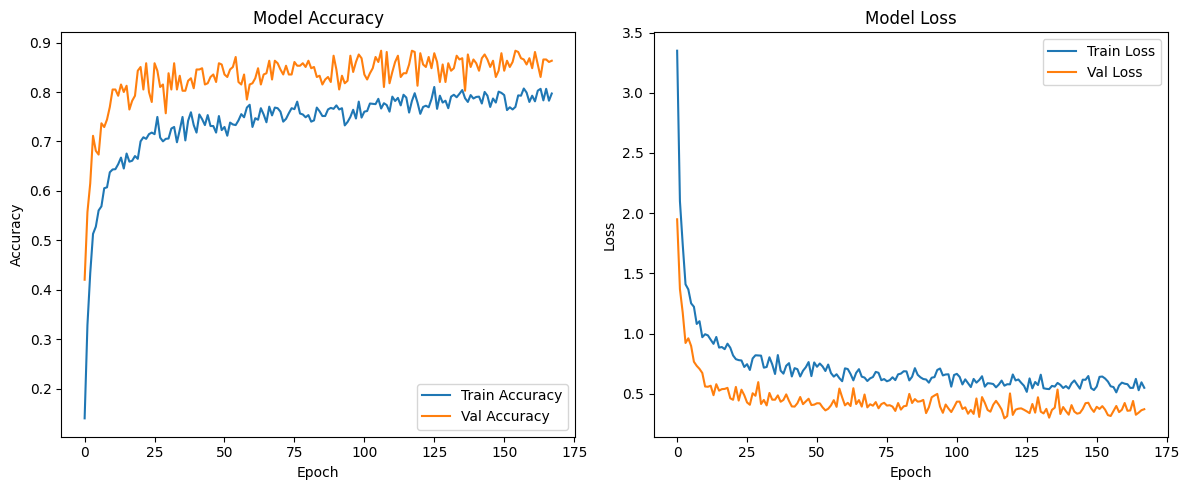

In [28]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

plot_training_history(history_initial)

# Fine Tuning

In [29]:
import keras_tuner as kt
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import Model

class FineTuneTuner(kt.HyperModel):
    def __init__(self, base_model, num_classes):
        self.base_model = base_model
        self.num_classes = num_classes
    
    def build(self, hp):
        trainable_layers = hp.Int('trainable_layers', min_value=5, max_value=50, step=5)
        for layer in self.base_model.layers[:-trainable_layers]:
            layer.trainable = False
        for layer in self.base_model.layers[-trainable_layers:]:
            layer.trainable = True

        inputs = tf.keras.Input(shape=IMAGE_SIZE)
        x = best_augmentation(inputs)

        x = self.base_model(x, training=True)
        x = GlobalAveragePooling2D()(x)

        x = Dense(512, activation='relu')(x)
        x = Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1))(x)
        outputs = Dense(self.num_classes, activation='softmax')(x)

        model = Model(inputs=inputs, outputs=outputs)

        model.compile(
            optimizer=tf.keras.optimizers.Adam(
                learning_rate=hp.Float('learning_rate', min_value=1e-6, max_value=1e-4, sampling='log')
            ),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        return model


In [36]:
tuner_fine_tune = kt.RandomSearch(
    FineTuneTuner(base_model, num_classes),
    objective='val_accuracy',
    max_trials=100,  
    executions_per_trial=1,
    directory='my_dir',
    project_name='fine_tune_hyperparameter_tuning'
)

tuner_fine_tune.oracle.max_trials = 9

early_stopping_fine_tune = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=100,
    restore_best_weights=True
)

stop_at_nine_callback = StopAtTrial(stop_trial=9)

tuner_fine_tune.search(
    train_dataset,
    validation_data=val_dataset,
    epochs=2500,
    callbacks=[early_stopping_fine_tune],
    verbose=1
)

Reloading Tuner from my_dir\fine_tune_hyperparameter_tuning\tuner0.json

Search: Running Trial #10

Value             |Best Value So Far |Hyperparameter
20                |45                |trainable_layers
0.2               |0.2               |dropout
2.0566e-06        |8.9298e-06        |learning_rate

Epoch 1/2500
50/50 ━━━━━━━━━━━━━━━━━━━━ 35s 564ms/step - accuracy: 0.0171 - loss: 4.3130 - val_accuracy: 0.0430 - val_loss: 3.8875
Epoch 2/2500
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 516ms/step - accuracy: 0.0214 - loss: 3.9741 - val_accuracy: 0.0532 - val_loss: 3.6184
Epoch 3/2500
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 555ms/step - accuracy: 0.0459 - loss: 3.6720 - val_accuracy: 0.0684 - val_loss: 3.3566
Epoch 4/2500
 3/50 ━━━━━━━━━━━━━━━━━━━━ 22s 469ms/step - accuracy: 0.0503 - loss: 3.4520

KeyboardInterrupt: 

In [38]:
tuner_fine_tune = kt.RandomSearch(
    FineTuneTuner(base_model, num_classes),
    objective='val_accuracy',
    max_trials=2,  
    executions_per_trial=1,
    directory='my_new_dir',
    project_name='fine_tune_hyperparameter_tuning'
)

early_stopping_fine_tune = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=100,
    restore_best_weights=True
)

tuner_fine_tune.search(
    train_dataset,
    validation_data=val_dataset,
    epochs=2500,
    callbacks=[early_stopping_fine_tune],
    verbose=1
)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
20                |20                |trainable_layers
0.2               |0.2               |dropout
1.7956e-06        |1.7956e-06        |learning_rate

Epoch 1/2500
50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 510ms/step - accuracy: 0.0291 - loss: 4.3262 - val_accuracy: 0.0354 - val_loss: 3.9644
Epoch 2/2500
32/50 ━━━━━━━━━━━━━━━━━━━━ 8s 464ms/step - accuracy: 0.0317 - loss: 4.1174

KeyboardInterrupt: 

In [39]:
best_fine_tune_model = tuner_fine_tune.get_best_models(num_models=1)[0]
best_fine_tune_hps = tuner_fine_tune.get_best_hyperparameters(num_trials=1)[0]

print("\nBest Hyperparameters for Fine-Tuning:")
print(f"Learning Rate: {best_fine_tune_hps.get('learning_rate')}")
print(f"Dropout: {best_fine_tune_hps.get('dropout')}")
print(f"Trainable Layers: {best_fine_tune_hps.get('trainable_layers')}")


Best Hyperparameters for Fine-Tuning:
Learning Rate: 1.7955858969577045e-06
Dropout: 0.2
Trainable Layers: 20


c:\Users\asus\Anaconda\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [40]:
print("\nAll Best Hyperparameters for Fine-Tuning:")
for param in best_fine_tune_hps.values:
    print(f"{param}: {best_fine_tune_hps.get(param)}")



All Best Hyperparameters for Fine-Tuning:
trainable_layers: 20
dropout: 0.2
learning_rate: 1.7955858969577045e-06


In [41]:
history_fine_tune = best_fine_tune_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=1000,
    callbacks=[early_stopping_fine_tune],
    verbose=1
)

Epoch 1/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 35s 568ms/step - accuracy: 0.0409 - loss: 4.0753 - val_accuracy: 0.0582 - val_loss: 3.7046
Epoch 2/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 556ms/step - accuracy: 0.0688 - loss: 3.8023 - val_accuracy: 0.1013 - val_loss: 3.4560
Epoch 3/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 542ms/step - accuracy: 0.0783 - loss: 3.5664 - val_accuracy: 0.1418 - val_loss: 3.2210
Epoch 4/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 552ms/step - accuracy: 0.1232 - loss: 3.3132 - val_accuracy: 0.2152 - val_loss: 3.0008
Epoch 5/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 550ms/step - accuracy: 0.1544 - loss: 3.1297 - val_accuracy: 0.2835 - val_loss: 2.7889
Epoch 6/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 529ms/step - accuracy: 0.2001 - loss: 2.8845 - val_accuracy: 0.3570 - val_loss: 2.5860
Epoch 7/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 510ms/step - accuracy: 0.2534 - loss: 2.7055 - val_accuracy: 0.4203 - val_loss: 2.3976
Epoch 8/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 514ms/step - accuracy: 0.3278 - loss: 2

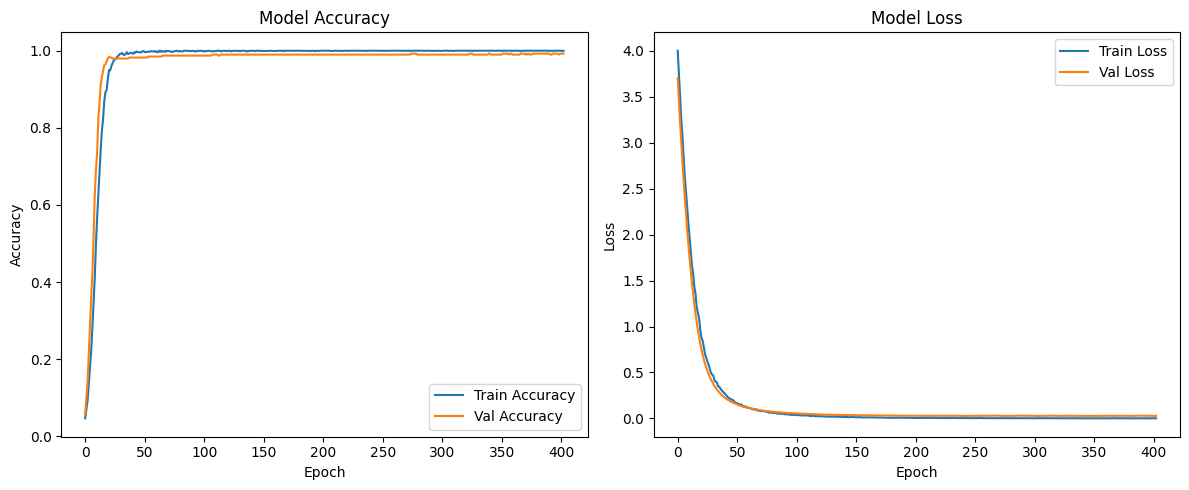

In [42]:
plot_training_history(history_fine_tune)

In [43]:
model.save('fine_tuned_model5.keras')

# Testing

In [44]:
test_loss, test_accuracy = best_fine_tune_model.evaluate(test_dataset)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 317ms/step - accuracy: 0.9968 - loss: 0.0189
Test Accuracy: 99.63%
Test Loss: 0.0195


# Save ke .keras

In [ ]:
def save_model(model, model_path):
    """
    Save model in different formats
    Args:
        model: trained Keras model
        model_path: base path for saving the model
    """
    try:
        model.save(f"{model_path}.keras")
        print("Saved in .keras format")
        
        model.export(f"{model_path}_savedmodel")
        print("Exported in SavedModel format")
        
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        tflite_model = converter.convert()
        with open(f"{model_path}.tflite", 'wb') as f:
            f.write(tflite_model)
        print("Saved in TFLite format")
        
        print("Model saved in all formats successfully!")
        
    except Exception as e:
        print(f"Error saving model: {str(e)}")

try:
    save_model(best_fine_tune_model, 'asl_model')
except Exception as e:
    print(f"Failed to save model: {str(e)}")

Saved in .keras format
INFO:tensorflow:Assets written to: asl_model_savedmodel\assets


INFO:tensorflow:Assets written to: asl_model_savedmodel\assets


Saved artifact at 'asl_model_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 36), dtype=tf.float32, name=None)
Captures:
  2291140804048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2291140803088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2291140804432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2291141869648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2291141870032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2291141870416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2291140795408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2291141871568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2291141870224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2291141871376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2291141871760: TensorSpec(sha

INFO:tensorflow:Assets written to: C:\Users\asus\AppData\Local\Temp\tmpbbubs4v4\assets


Saved artifact at 'C:\Users\asus\AppData\Local\Temp\tmpbbubs4v4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 36), dtype=tf.float32, name=None)
Captures:
  2291140795408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2291141871568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2291141870224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2291141871376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2291141871760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2291141872144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2291141873488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2291141873680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2291141873296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2291141872528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  22911

# Confussion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


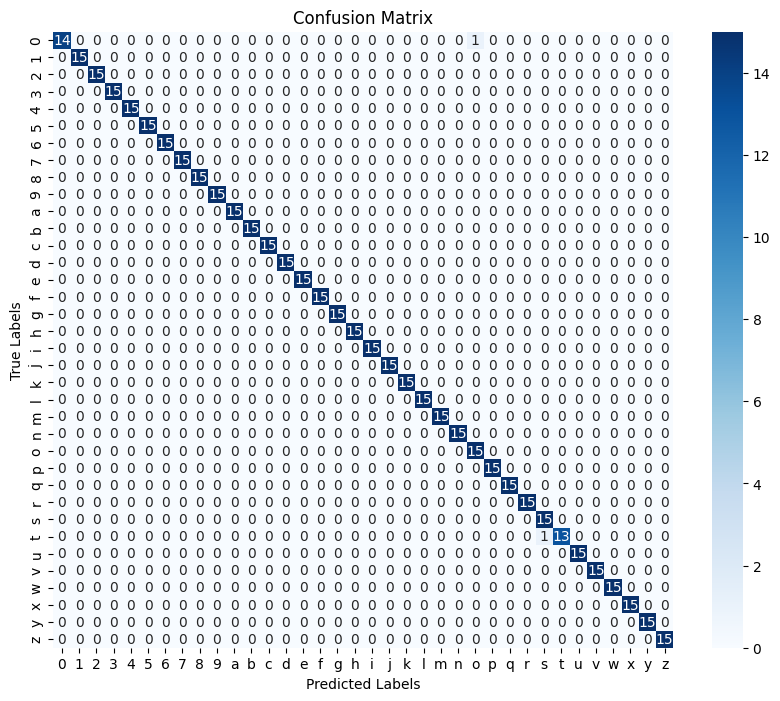

In [53]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

class_names = train_dataset.class_names
y_pred = []
y_true = []

for images, labels in test_dataset:
    predictions = best_fine_tune_model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Convert ke TF Lite

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model('asl_model.keras')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('asl_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model berhasil dikonversi ke format TensorFlow Lite dan disimpan sebagai 'asl_model.tflite'")

INFO:tensorflow:Assets written to: C:\Users\asus\AppData\Local\Temp\tmph6bwj_61\assets


INFO:tensorflow:Assets written to: C:\Users\asus\AppData\Local\Temp\tmph6bwj_61\assets


Saved artifact at 'C:\Users\asus\AppData\Local\Temp\tmph6bwj_61'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 36), dtype=tf.float32, name=None)
Captures:
  1877082266640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1877082267408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1877082267600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1877082267216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1877082266256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1877082267984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1877082269328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1877082269520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1877082269136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1877082268368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  187708